In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df =  pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [3]:
df.head(4)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants


In [4]:
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(' ','_')
              .str.replace(r'[^\w_]','',regex=True) # remove non-alphanumeric characters
)

In [5]:
#check info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   unnamed_0                23486 non-null  int64 
 1   clothing_id              23486 non-null  int64 
 2   age                      23486 non-null  int64 
 3   title                    19676 non-null  object
 4   review_text              22641 non-null  object
 5   rating                   23486 non-null  int64 
 6   recommended_ind          23486 non-null  int64 
 7   positive_feedback_count  23486 non-null  int64 
 8   division_name            23472 non-null  object
 9   department_name          23472 non-null  object
 10  class_name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [6]:
#droping the unwanted columns 
df.drop(columns=['unnamed_0'],inplace=True)

In [7]:
# check shape 
df.shape

(23486, 10)

In [8]:
# check duplicate values 
df.duplicated().sum()

21

In [9]:
# Removing duplicate values 
df = df.drop_duplicates(keep='first')

In [10]:
#check for missing values 
df.isnull().sum()

clothing_id                   0
age                           0
title                      3789
review_text                 825
rating                        0
recommended_ind               0
positive_feedback_count       0
division_name                14
department_name              14
class_name                   14
dtype: int64

In [11]:
# Dropping the missing values
df = df.dropna()

In [12]:
df.isnull().sum()

clothing_id                0
age                        0
title                      0
review_text                0
rating                     0
recommended_ind            0
positive_feedback_count    0
division_name              0
department_name            0
class_name                 0
dtype: int64

In [13]:
df.shape

(19662, 10)

#### Analysing the rating column

In [14]:
df['rating'].value_counts()

rating
5    10858
4     4289
3     2464
2     1360
1      691
Name: count, dtype: int64

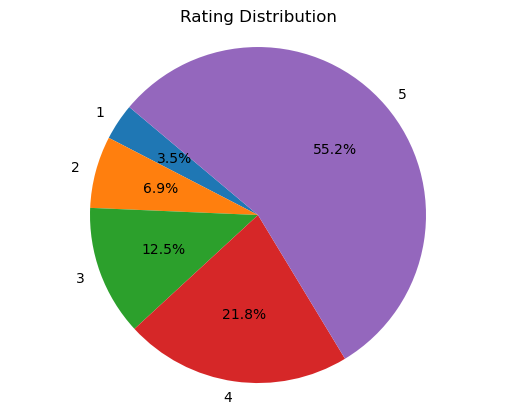

In [15]:
# rating distribution 
rating_count = df['rating'].value_counts().sort_index()
plt.pie(rating_count,labels = rating_count.index, autopct='%1.1f%%',startangle=140)
plt.title('Rating Distribution')
plt.axis('equal')
plt.show()

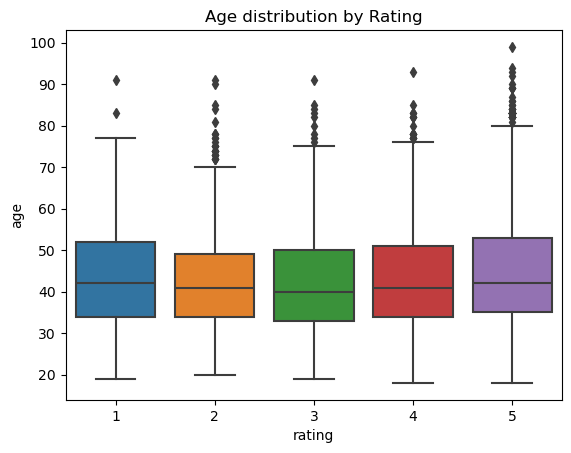

In [16]:
# Visualizing the spread of ages for each rating category
sns.boxplot(x='rating',y='age',data=df)
plt.title('Age distribution by Rating')
plt.xlabel('rating')
plt.ylabel('age')
plt.show()

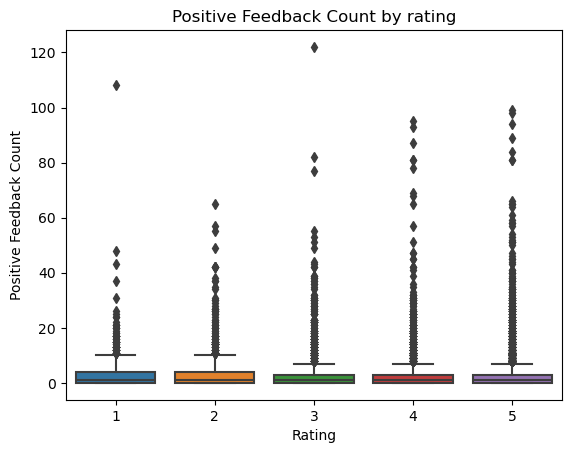

In [17]:
# Shows how positive feedback varies with rating
sns.boxplot(x = 'rating', y = 'positive_feedback_count', data=df)
plt.title("Positive Feedback Count by rating")
plt.xlabel('Rating')
plt.ylabel('Positive Feedback Count')
plt.show()

#### Analyzing the Recommended IND column 

In [18]:
df['recommended_ind'].value_counts()

recommended_ind
1    16087
0     3575
Name: count, dtype: int64

data is imbalance

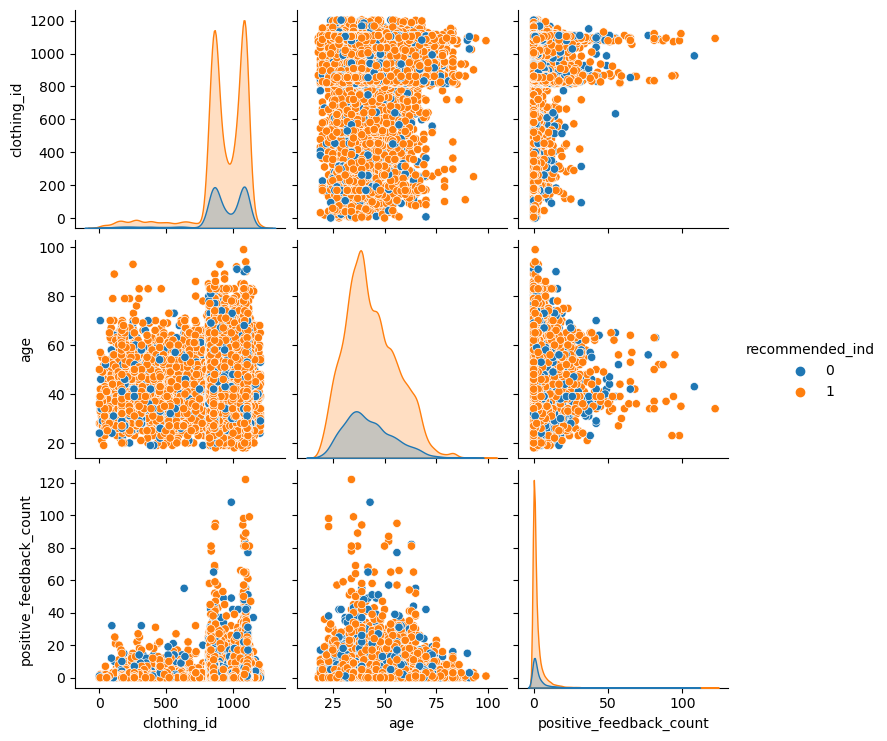

In [19]:
sns.pairplot(
    df[['clothing_id', 'age','recommended_ind', 'positive_feedback_count']],
    hue="recommended_ind",
    diag_kind="kde"
)

In [20]:
# Count the number of each rating where the product was not recommended 
df[df['recommended_ind'] == 0]['rating'].value_counts()

rating
3    1444
2    1280
1     684
4     146
5      21
Name: count, dtype: int64

In [21]:
# Count the number of each rating where the product was recommended
df[df['recommended_ind'] == 1]['rating'].value_counts()

rating
5    10837
4     4143
3     1020
2       80
1        7
Name: count, dtype: int64

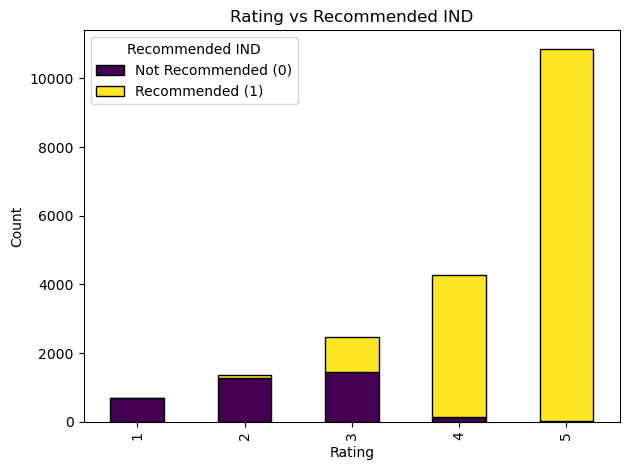

In [22]:
# Comparing how recommendation status varies across different rating levels
rat_vs_rec = pd.crosstab(df['rating'], df['recommended_ind'])
rat_vs_rec.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating vs Recommended IND')
plt.legend(title='Recommended IND', labels=['Not Recommended (0)', 'Recommended (1)'])
plt.tight_layout()
plt.show()

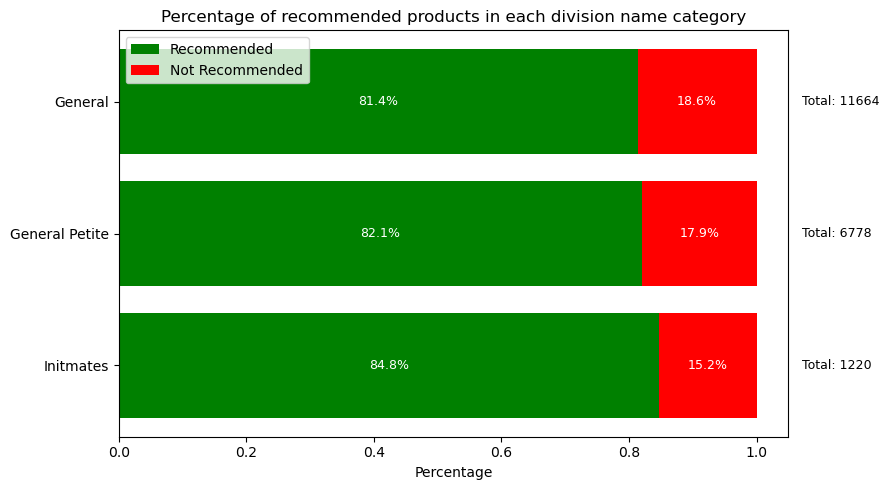

In [23]:
# Group by division and recommended status
division_group = df.groupby(['division_name', 'recommended_ind']).size().unstack(fill_value=0)

# Rename columns for clarity
division_group.columns = ['Not Recommended', 'Recommended']

# Calculate totals and percentages
division_group['Total'] = division_group['Recommended'] + division_group['Not Recommended']
division_group['Recommended %'] = division_group['Recommended'] / division_group['Total']
division_group['Not Recommended %'] = division_group['Not Recommended'] / division_group['Total']

# Sort by Recommended %
division_group = division_group.sort_values(by='Recommended %', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(9,5))   # wider for labels

ax.barh(division_group.index, division_group['Recommended %'], color='green', label='Recommended')
ax.barh(division_group.index, division_group['Not Recommended %'], 
        left=division_group['Recommended %'], color='red', label='Not Recommended')

# Add percentage labels inside bars
for i, (rec, not_rec, total) in enumerate(zip(division_group['Recommended %'], 
                                              division_group['Not Recommended %'], 
                                              division_group['Total'])):
    ax.text(rec/2, i, f"{rec*100:.1f}%", va='center', ha='center', color='white', fontsize=9)
    ax.text(rec + not_rec/2, i, f"{not_rec*100:.1f}%", va='center', ha='center', color='white', fontsize=9)
    
    ax.text(1.02, i, f"Total: {total}", va='center', ha='left', fontsize=9, transform=ax.get_yaxis_transform())

ax.set_title("Percentage of recommended products in each division name category")
ax.set_xlabel("Percentage")
ax.legend()

plt.tight_layout()
plt.show()

## Analying the Text Column 

In [24]:
def sentiment_rating(rating):
    return 'positive' if rating >= 4 else 'negative'

df['sentiment'] = df['rating'].apply(sentiment_rating)

In [25]:
#def sentiment_rate(rating):
 #   if rating <=2:
 #       return 'negative'
 #   elif rating == 3:
#        return 'neutral'
#    else:
#        return 'positive'

#df['sentiment'] = df['rating'].apply(sentiment_rate)

In [26]:
df['sentiment'].value_counts()

sentiment
positive    15147
negative     4515
Name: count, dtype: int64

- Data is Imbalanced 

In [27]:
# number of characters in each review
df['text_len'] = df['review_text'].apply(len)

In [28]:
 df.loc[10, 'review_text']

'Dress runs small esp where the zipper area runs. i ordered the sp which typically fits me and it was very tight! the material on the top looks and feels very cheap that even just pulling on it will cause it to rip the fabric. pretty disappointed as it was going to be my christmas dress this year! needless to say it will be going back.'

In [29]:
# number of words in each review
df['num_word'] = df['review_text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [30]:
df['num_sentence'] = df['review_text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [31]:
df.head(2)

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name,sentiment,text_len,num_word,num_sentence
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,negative,500,110,5
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,positive,124,31,3


In [32]:
df[['text_len', 'num_word','num_sentence']].describe()

,text_len,num_word,num_sentence
count,19662.000000,19662.000000,19662.000000
mean,318.444817,71.694436,4.881141
std,142.268450,32.218157,2.059207
min,9.000000,2.000000,1.000000
25%,199.000000,45.000000,3.000000
50%,315.000000,71.000000,5.000000
75%,475.000000,103.000000,6.000000
max,508.000000,139.000000,17.000000


In [33]:
#Encode the 'sentiment' column into numeric labels (negative 0 / positive = 1 ) for model training
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])

In [34]:
# descriptive statistics for negative sentiment reviews (sentiment == 0)
df[df['sentiment'] == 0 ][['text_len', 'num_word','num_sentence']].describe()

,text_len,num_word,num_sentence
count,4515.000000,4515.000000,4515.000000
mean,330.375858,74.240753,4.807309
std,136.509667,30.740662,2.039723
min,20.000000,4.000000,1.000000
25%,216.000000,49.000000,3.000000
50%,332.000000,75.000000,5.000000
75%,484.500000,104.000000,6.000000
max,508.000000,139.000000,16.000000


In [35]:
# descriptive statistics for positive sentiment reviews (sentiment == 1)
df[df['sentiment'] == 1][['text_len', 'num_word','num_sentence']].describe()

,text_len,num_word,num_sentence
count,15147.000000,15147.000000,15147.000000
mean,314.888427,70.935433,4.903149
std,143.753377,32.608169,2.064536
min,9.000000,2.000000,1.000000
25%,192.000000,43.000000,3.000000
50%,310.000000,70.000000,5.000000
75%,471.000000,103.000000,6.000000
max,508.000000,131.000000,17.000000


[Text(0.5, 1.0, 'Distribution of length of review if sentiment is negative')]

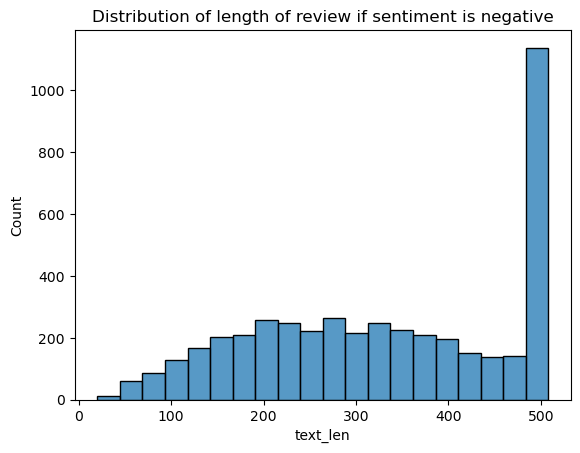

In [36]:
sns.histplot(df[df['sentiment'] == 0]['text_len'],bins=20).set(title='Distribution of length of review if sentiment is negative')

[Text(0.5, 1.0, 'Distribution of length of review if sentiment is positive')]

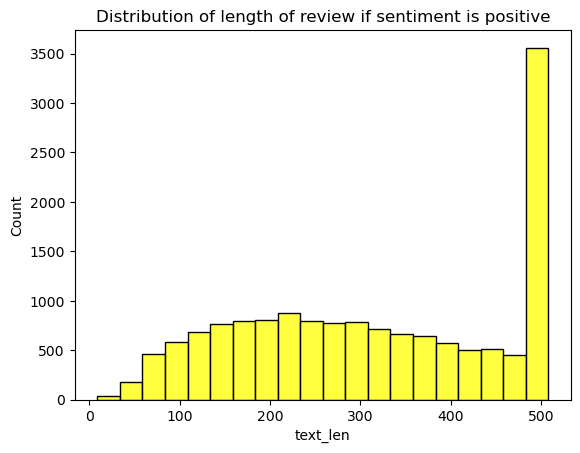

In [37]:
sns.histplot(df[df['sentiment']==1]['text_len'],color='yellow',bins=20).set(title='Distribution of length of review if sentiment is positive')

### Data Preprocessing and Modelling 

To prepare the `review_text` column for sentiment analysis, we applied the following steps:

- Converted text to **lowercase**  
- **Tokenized** reviews into words  
- Removed **non-alphanumeric** characters  
- Removed **English stopwords**  
- Applied **POS tagging** for context-aware lemmatization  
- **Lemmatized** words to their base form  
- Combined the cleaned words into the final `transformed_text` column corpus

In [38]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string

# Download these once
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def transform_text(text):
    # Lowercase
    text = text.lower()
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove non-alphanumeric
    tokens = [word for word in tokens if word.isalnum()]
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # POS tagging
    pos_tags = nltk.pos_tag(tokens)
    
    # Lemmatize with POS
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    
    return " ".join(tokens)


In [39]:
#!pip install autocorrect
#!pip install contractions

In [40]:
df['review_text'][17]

"Took a chance on this blouse and so glad i did. i wasn't crazy about how the blouse is photographed on the model. i paired it whit white pants and it worked perfectly. crisp and clean is how i would describe it. launders well. fits great. drape is perfect. wear tucked in or out - can't go wrong."

In [41]:
transform_text("Took a chance on this blouse and so glad i did. i wasn't crazy about how the blouse is photographed on the model. i paired it whit white pants and it worked perfectly. crisp and clean is how i would describe it. launders well. fits great. drape is perfect. wear tucked in or out - can't go wrong.")

'take chance blouse glad crazy blouse photograph model pair whit white pant work perfectly crisp clean would describe launders well fit great drape perfect wear tuck ca go wrong'

In [42]:
df['transformed_text'] = df['review_text'].apply(transform_text)

In [43]:
df.head(2)

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name,sentiment,text_len,num_word,num_sentence,transformed_text
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0,500,110,5,high hope dress really wanted work initially o...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,1,124,31,3,love love love jumpsuit fun flirty fabulous ev...


In [44]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')


The code creates a **WordCloud** object to visually display text data, where **word size reflects frequency**.  
Useful for **highlighting important or frequent words** in a simple, visual formt.


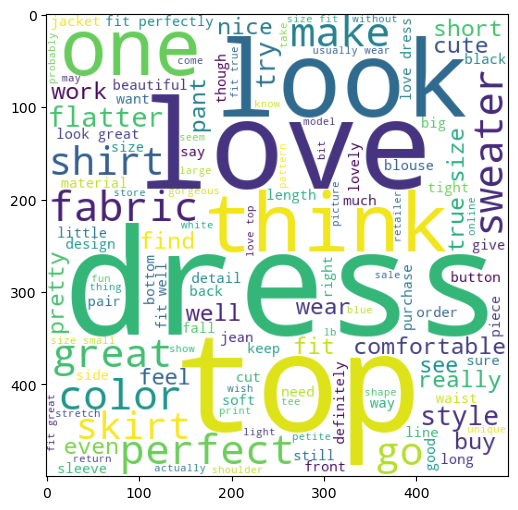

In [45]:
pos_wc = wc.generate(df[df['sentiment'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(pos_wc)

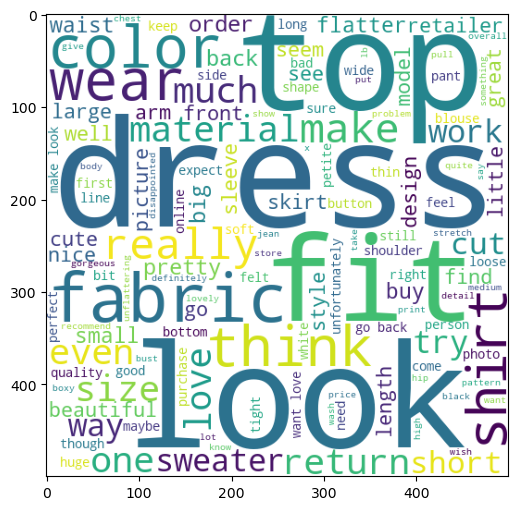

In [46]:
neg_wc = wc.generate(df[df['sentiment'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(neg_wc)

In [47]:
df.shape 

(19662, 15)

In [48]:
#from sklearn.feature_extraction.text import CountVectorizer
#cv = CountVectorizer(max_features=2500)
#X = cv.fit_transform(df['transformed_text']).toarray()
#y = df['sentiment']

In [49]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv= CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['sentiment']

In [50]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (19662, 3000)
y shape: (19662,)


### Data Modeling

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
svc = LinearSVC(C=0.001, class_weight = 'balanced', random_state = 42)
mnb = MultinomialNB(alpha = 2.1,force_alpha = True, fit_prior = False)
lrc = LogisticRegression(C = 0.01, class_weight = "balanced", max_iter=1000)

In [53]:
clfs = {
    'SVC': svc,
    'NB': mnb,
    'LR': lrc
}

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval_on_datasets(clf, X_train, y_train, X_test, y_test):
    # 1. Fit on training data
    clf.fit(X_train, y_train)
    
    # 2. Predict on training data
    y_train_pred = clf.predict(X_train)
    train_accuracy  = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='macro')
    train_recall    = recall_score(y_train, y_train_pred, average='macro')
    train_f1        = f1_score(y_train, y_train_pred, average='macro')
    
    # 3. Predict on test data
    y_test_pred = clf.predict(X_test)
    test_accuracy  = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='macro')
    test_recall    = recall_score(y_test, y_test_pred, average='macro')
    test_f1        = f1_score(y_test, y_test_pred, average='macro')
    
    # 4. Return both sets of metrics
    return {
        'train': {
            'accuracy': train_accuracy,
            'precision': train_precision,
            'recall': train_recall,
            'f1': train_f1
        },
        'test': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1
        }
    }

# Evaluate all classifiers
results = {}
for name, clf in clfs.items():
    scores = eval_on_datasets(clf, X_train, y_train, X_test, y_test)
    results[name] = scores

# Display results
import pandas as pd

rows = []
for name, score_dict in results.items():
    row = {
        'Model': name,
        'Train Acc': score_dict['train']['accuracy'],
        'Test Acc':  score_dict['test']['accuracy'],
        'Train Prec': score_dict['train']['precision'],
        'Test Prec':  score_dict['test']['precision'],
        'Train Rec':  score_dict['train']['recall'],
        'Test Rec':   score_dict['test']['recall'],
        'Train F1':   score_dict['train']['f1'],
        'Test F1':    score_dict['test']['f1'],
    }
    rows.append(row)

df_results = pd.DataFrame(rows)

# Set 'Model' as index and transpose the DataFrame
df_results_transposed = df_results.set_index('Model').T
print(df_results_transposed)

Model            SVC        NB        LR
Train Acc   0.814801  0.869477  0.816517
Test Acc    0.815917  0.849225  0.816934
Train Prec  0.756473  0.812656  0.757910
Test Prec   0.750665  0.778005  0.751533
Train Rec   0.824480  0.844965  0.825408
Test Rec    0.829229  0.819317  0.829879
Train F1    0.774492  0.826505  0.776126
Test F1     0.770539  0.794617  0.771549


In [55]:
from sklearn.ensemble import VotingClassifier

nb = MultinomialNB()
lr = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
svc = LinearSVC(class_weight="balanced", random_state=42)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[("nb", nb), ("lr", lr), ("svc", svc)],
    voting="hard"   # or "soft" if all support predict_proba
)

In [56]:
from sklearn.model_selection import cross_validate, StratifiedKFold

scoring = ['accuracy', 'precision', 'recall', 'f1'] 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(voting_clf, X, y, cv=cv, scoring=scoring)

print("Cross-validated scores:")
print(f"Accuracy : {scores['test_accuracy'].mean():.4f}")
print(f"Precision: {scores['test_precision'].mean():.4f}")
print(f"Recall   : {scores['test_recall'].mean():.4f}")
print(f"F1-score : {scores['test_f1'].mean():.4f}")


Cross-validated scores:
Accuracy : 0.8611
Precision: 0.9300
Recall   : 0.8864
F1-score : 0.9076
